On Training datasets
Accuracy: 0.6544795783926218
classification report 
               precision    recall  f1-score   support

        ENFJ       0.30      0.44      0.36       133
        ENFP       0.55      0.61      0.58       472
        ENTJ       0.44      0.54      0.48       162
        ENTP       0.69      0.62      0.65       479
        ESFJ       0.15      0.24      0.18        29
        ESFP       0.17      0.50      0.25        34
        ESTJ       0.13      0.26      0.18        27
        ESTP       0.27      0.53      0.36        62
        INFJ       0.79      0.65      0.72      1029
        INFP       0.83      0.70      0.76      1282
        INTJ       0.67      0.75      0.71       764
        INTP       0.78      0.68      0.73       913
        ISFJ       0.43      0.56      0.49       116
        ISFP       0.53      0.56      0.55       190
        ISTJ       0.46      0.66      0.54       144
        ISTP       0.59      0.65      0.62       236

    ac

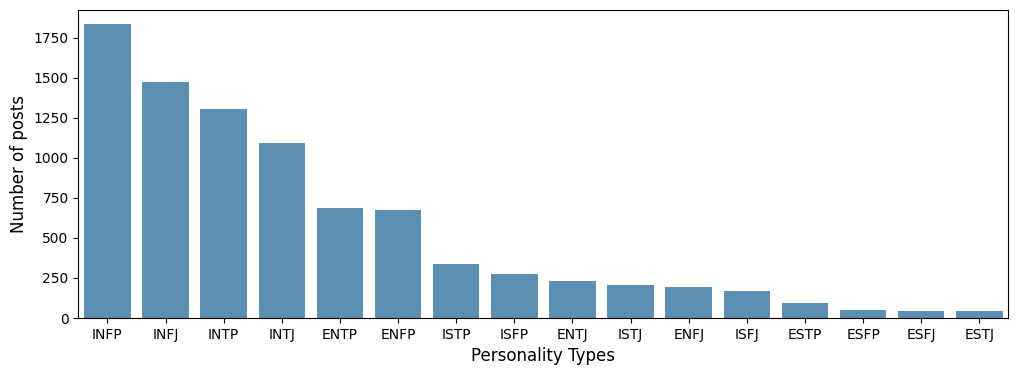

In [ ]:





import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
# drive.mount('/content/drive')

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score # better metric
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC,LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import warnings
warnings.filterwarnings('ignore')
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer

# data_path="/mbti_1.csv"
data_path = "/content/drive/MyDrive/mbti_1.csv"
df = pd.read_csv(data_path)

df.head()

"""Pre-Processing """

def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))

    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))

    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x))

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data.
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")

    return df
stopwords = STOP_WORDS

def preprocess(train):

    doc = nlp(train, disable = ['ner', 'parser'])
    lemmas = [token.lemma_ for token in doc]
    a_lemma = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stopwords ]
    return ' ' .join(a_lemma)

# Making use of the clean_data function
all_data=preprocess_text(df)
all_data['posts2']= all_data['posts'].apply(preprocess)
all_data['posts3']=[''.join(post) for post in all_data['posts2']]

all_data.head()

#Total number of posts for each personality type
personality_types = all_data['type'].value_counts()


plt.figure(figsize=(12, 4))
sns.barplot(x=personality_types.index, y=personality_types.values, alpha=0.8)
plt.ylabel('Number of posts', fontsize=12)
plt.xlabel('Personality Types', fontsize=12)


"""Splitting into train and test"""

# splitting data to training and testing data set...
from sklearn.model_selection import train_test_split
def splitting(file1,testratio):
  p={}
  for k in file1:
    if(k!="type"):
      p.update({k:file1[k]})
  X = pd.DataFrame(p)
  # X=X.values
  Y= file1["type"]
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = testratio,stratify=Y,random_state=42)
  return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitting (all_data,0.3)

df_train=pd.concat([y_train,X_train],axis=1)
df_train.head()
df_test=pd.concat([y_test,X_test],axis=1)
df_test.head()

all_data_pre=pd.concat([df_train,df_test])

"""Vectorizing"""

# Create the transform
vectorizer = TfidfVectorizer(ngram_range=(1,1), analyzer='word' ,stop_words='english')
all_data_post = vectorizer.fit_transform(all_data_pre['posts3'])

# Demerging the train and test dataframe from the all_data dataframe.
len_slice = df_train.shape[0]
# Slice train data frame from all_data dataframe
train = all_data_post[:len_slice]
# Slice test data frame from all_data dataframe
test = all_data_post[len_slice:]
# Target variable
y = df_train['type']

# print(train)

# print(y)

# Applying the encoding to the target variable y

# Mind: Introverted (I) or Extraverted (E)
# Energy: Sensing (S) or Intuitive (N)
# Nature: Feeling (F) or Thinking (T)
# Tactics: Perceiving (P) or Judging (J)

mind = y.apply(lambda x: 0 if x[0] == 'I' else 1)
energy = y.apply(lambda x: 0 if x[1] == 'S' else 1)
nature = y.apply(lambda x: 0 if x[2] == 'F' else 1)
tactics = y.apply(lambda x: 0 if x[3] == 'P' else 1)

"""decoding the target variable """

def conversion(data):
  val=data.values
  di=[]
  for k in val:
    se=""
    if(k[0]==0):
      se+="I"
    else:
      se+='E'
    if(k[1]==0):
      se+="S"
    else:
      se+='N'
    if(k[2]==0):
      se+="F"
    else:
      se+='T'
    if(k[3]==0):
      se+="P"
    else:
      se+='J'
    di.append(se)
  return di

"""Accuracies and reports"""

def reports(train,train_pred,test,test_pred):
  print("On Training datasets")
  print("Accuracy:",accuracy_score(train, train_pred))
  print('classification report \n',classification_report(train,train_pred))
  print("Confusion Matrix \n ",confusion_matrix(train,train_pred))

  print("On Test datasets")
  print("Accuracy:",accuracy_score(test, test_pred))
  print('classification report \n',classification_report(test,test_pred))
  print("Confusion Matrix \n ",confusion_matrix(test,test_pred))

"""# Models

Logistic Regression
"""

def Logistic_Regression(train_df, test_df, cate_df):
    # Instantiating the object
    classifier = LogisticRegression(random_state=0,class_weight='balanced')
    classifier.fit(train_df, cate_df)
    # Predictions on the train dataframe
    prediction_train = pd.DataFrame(classifier.predict(train_df))
    # Predictions on the test dataframe
    prediction_test = pd.DataFrame(classifier.predict(test_df))
    return prediction_train,prediction_test

# Applying the Logistic_Regression function on the category data
M_train_prediction,M_test_prediction = Logistic_Regression(train, test, mind)
E_train_prediction,E_test_prediction = Logistic_Regression(train, test, energy)
N_train_prediction,N_test_prediction = Logistic_Regression(train, test, nature)
T_train_prediction,T_test_prediction = Logistic_Regression(train, test, tactics)

# Concatenating our predictions into one dataframe
sub_train_1 = pd.concat([M_train_prediction,E_train_prediction,N_train_prediction,T_train_prediction], axis=1)
sub_test_1 = pd.concat([M_test_prediction,E_test_prediction,N_test_prediction,T_test_prediction], axis=1)

sub_train_1.columns = [ 'mind', 'energy', 'nature', 'tactics']
sub_test_1.columns = [ 'mind', 'energy', 'nature', 'tactics']

sub_train_1.head()

logistic_val=conversion(sub_train_1)
logistic_test=conversion(sub_test_1)
reports(df_train["type"],logistic_val,df_test["type"],logistic_test)

"""Random_forest"""

from sklearn.ensemble import RandomForestClassifier
def Randomforest_Classifier(train_df, test_df, cate_df):
  rfc = RandomForestClassifier(n_estimators=30, min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=123)
  rfc.fit(train_df, cate_df)
  # Predictions on the train dataframe
  prediction_train = pd.DataFrame( rfc.predict(train_df))
    # Predictions on the test dataframe
  prediction_test = pd.DataFrame( rfc.predict(test_df))
  return prediction_train,prediction_test

# Applying the Logistic_Regression function on the mind category
M_train_prediction3,M_test_prediction3 =Randomforest_Classifier(train, test, mind)
E_train_prediction3,E_test_prediction3 =Randomforest_Classifier(train, test, energy)
N_train_prediction3,N_test_prediction3 =Randomforest_Classifier(train, test, nature)
T_train_prediction3,T_test_prediction3 =Randomforest_Classifier(train, test, tactics)

# Concatenating our predictions into one dataframe
sub_train_3= pd.concat([M_train_prediction3,E_train_prediction3,N_train_prediction3,T_train_prediction3], axis=1)
sub_test_3= pd.concat([M_test_prediction3,E_test_prediction3,N_test_prediction3,T_test_prediction3], axis=1)

rf_val=conversion(sub_train_3)
rf_test=conversion(sub_test_3)
reports(df_train["type"],rf_val,df_test["type"],rf_test)

"""LightGBM"""

import lightgbm as lgb
def lgbm_classifier(train_df, test_df, cate_df):
  m1 = lgb.LGBMClassifier(n_estimators=100, min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=42)
  m1.fit(train_df,cate_df)
  # Predictions on the train dataframe
  prediction_train = pd.DataFrame(m1.predict(train_df))
    # Predictions on the test dataframe
  prediction_test = pd.DataFrame(m1.predict(test_df))
  return prediction_train,prediction_test

# Applying the Logistic_Regression function on the mind category
M_train_prediction4,M_test_prediction4 =lgbm_classifier(train, test, mind)
E_train_prediction4,E_test_prediction4 =lgbm_classifier(train, test, energy)
N_train_prediction4,N_test_prediction4 =lgbm_classifier(train, test, nature)
T_train_prediction4,T_test_prediction4 =lgbm_classifier(train, test, tactics)

# Concatenating our predictions into one dataframe
sub_train_4= pd.concat([M_train_prediction4,E_train_prediction4,N_train_prediction4,T_train_prediction4], axis=1)
sub_test_4= pd.concat([M_test_prediction4,E_test_prediction4,N_test_prediction4,T_test_prediction4], axis=1)

lg_val=conversion(sub_train_4)
lg_test=conversion(sub_test_4)
reports(df_train["type"],lg_val,df_test["type"],lg_test)

"""Multinomial Naive Bayes"""

from sklearn.naive_bayes import MultinomialNB
def multinomial(train_df, test_df, cate_df):
  gnb=MultinomialNB()
  gnb.fit(train_df,cate_df)
  # Predictions on the train dataframe
  prediction_train = pd.DataFrame(gnb.predict(train_df))
    # Predictions on the test dataframe
  prediction_test = pd.DataFrame(gnb.predict(test_df))
  return prediction_train,prediction_test

# Applying the Logistic_Regression function on the mind category
M_train_prediction5,M_test_prediction5 =multinomial(train, test, mind)
E_train_prediction5,E_test_prediction5 =multinomial(train, test, energy)
N_train_prediction5,N_test_prediction5 =multinomial(train, test, nature)
T_train_prediction5,T_test_prediction5 =multinomial(train, test, tactics)

# Concatenating our predictions into one dataframe
sub_train_5= pd.concat([M_train_prediction5,E_train_prediction5,N_train_prediction5,T_train_prediction5], axis=1)
sub_test_5= pd.concat([M_test_prediction5,E_test_prediction5,N_test_prediction5,T_test_prediction5], axis=1)

gnb_val=conversion(sub_train_5)
gnb_test=conversion(sub_test_5)
reports(df_train["type"],gnb_val,df_test["type"],gnb_test)

"""# Best Model LGBM"""

def lgbm_classifier_deploy(train_df,  cate_df):
  m1 = lgb.LGBMClassifier(n_estimators=100, min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=42)
  m1.fit(train_df,cate_df)
  return m1

models=[]
models.append(lgbm_classifier_deploy(train,mind))
models.append(lgbm_classifier_deploy(train,energy))
models.append(lgbm_classifier_deploy(train,nature))
models.append(lgbm_classifier_deploy(train,tactics))

def pipeline(inp,vectorizer,models):
  inp = preprocess(inp)
  inp_vec=vectorizer.transform([inp])
  k=[]
  for model in models:
    output=model.predict(inp_vec)
    k.append(output)

  se=""
  if(k[0]==0):
    se+="I"
  else:
    se+='E'
  if(k[1]==0):
    se+="S"
  else:
    se+='N'
  if(k[2]==0):
    se+="F"
  else:
    se+='T'
  if(k[3]==0):
    se+="P"
  else:
    se+='J'
  print(se)
  return se

string = all_data['posts3'][0]
pipeline(string,vectorizer,models)

print(len(all_data['posts3'][5]))

print((all_data['posts3'][5]))